In [ ]:
# --- 1. SETUP & INSTALLATION ---

!pip install transformers sentencepiece tqdm

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer,  get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm.auto import tqdm

print("✅ Libraries installed and imported.")

✅ Libraries installed and imported.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Merged_GBV_final (1).csv to Merged_GBV_final (1).csv


In [ ]:
# --- 2. CONFIGURATION ---
class Config:
    MAX_LEN = 128           # Context window
    BATCH_SIZE = 16         # 16 fits fine for Base. Use 8 if using Large.
    EPOCHS = 6              # DeBERTa learns fast, 6 epochs is usually enough
    LEARNING_RATE = 1e-5    # Standard for DeBERTa
    # SWITCHING TO DeBERTa V3 BASE
    MODEL_NAME = "microsoft/deberta-v3-base"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SAVE_NAME = "best_model_deberta.bin"
    CSV_FILE = 'Merged_GBV_final (1).csv'

print(f"🚀 Initializing {Config.MODEL_NAME} on {Config.DEVICE}...")

🚀 Initializing microsoft/deberta-v3-base on cuda...


In [ ]:
try:
    df = pd.read_csv(Config.CSV_FILE)


    # 1. Map Binary Labels
    df['binary_target'] = df['Label'].map({'non-crime': 0, 'crime': 1})

    # 2. Map Multi-class Labels
    unique_crimes = sorted(df['crime_type'].unique())
    crime_map = {label: idx for idx, label in enumerate(unique_crimes)}
    df['multi_target'] = df['crime_type'].map(crime_map)

    print(f"   Mapped Crime Types: {crime_map}")

    # 3. Compute Class Weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df['multi_target']),
        y=df['multi_target']
    )
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(Config.DEVICE)
    print(f"   ⚖️ Class Weights: {class_weights}")

    # 4. Split Data
    train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['multi_target'])
    print(f"   Training samples: {len(train_df)} | Validation samples: {len(val_df)}")

except FileNotFoundError:
    print("❌ ERROR: Dataset file not found. Please upload csv.")

   Mapped Crime Types: {'Armed Combat & Weaponry': 0, 'Counter-Terrorism & Arrests': 1, 'Crimes Against Civilians': 2, 'Extremist Propaganda': 3, 'non-crime': 4, 'sexual_violence': 5}
   ⚖️ Class Weights: [1.2005624  4.04429083 0.92347714 0.94842699 0.51695137 1.17905658]
   Training samples: 13427 | Validation samples: 2370


In [ ]:
df.head()

,Tweet,Label,crime_type,binary_target,multi_target
0,islamicstate wilayatalanbar destruction of num...,crime,Armed Combat & Weaponry,1,0
1,you traded the duny for the akhirah something ...,non-crime,non-crime,0,4
2,morthroadsafety dtptraffic pib india what if t...,non-crime,non-crime,0,4
3,haqq witness clearing up misconceptions about ...,non-crime,non-crime,0,4
4,meiyinkun5 raqqa sl the crusaders love much mu...,crime,Extremist Propaganda,1,3


In [ ]:
# --- 4. DATASET & TOKENIZER ---

class TweetDataset(Dataset):
    def __init__(self, tweets, binary_labels, multi_labels, tokenizer, max_len):
        self.tweets = tweets
        self.binary_labels = binary_labels
        self.multi_labels = multi_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        encoding = self.tokenizer.encode_plus(
            tweet,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'binary_label': torch.tensor(self.binary_labels[item], dtype=torch.float),
            'multi_label': torch.tensor(self.multi_labels[item], dtype=torch.long)
        }

# Initialize DeBERTa Tokenizer
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

train_loader = DataLoader(
    TweetDataset(train_df.Tweet.values, train_df.binary_target.values, train_df.multi_target.values, tokenizer, Config.MAX_LEN),
    batch_size=Config.BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    TweetDataset(val_df.Tweet.values, val_df.binary_target.values, val_df.multi_target.values, tokenizer, Config.MAX_LEN),
    batch_size=Config.BATCH_SIZE
)
print("✅ DeBERTa DataLoaders ready.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


✅ DeBERTa DataLoaders ready.


In [ ]:
# --- 5. MODEL ARCHITECTURE (DeBERTa) ---

class DebertaTwoBrain(nn.Module):
    def __init__(self, n_classes):
        super(DebertaTwoBrain, self).__init__()
        # Load DeBERTa V3
        self.bert = AutoModel.from_pretrained(Config.MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)

        # Get hidden size (768 for Base)
        hidden_size = self.bert.config.hidden_size

        # Head 1: Binary
        self.binary_head = nn.Linear(hidden_size, 1)

        # Head 2: Multi-class
        self.multi_head = nn.Linear(hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # 1. Shared Encoder
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # 2. Extract [CLS] Token (Context Vector)
        # DeBERTa outputs the sequence, we take the first token (Index 0)
        cls_token = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.drop(cls_token)

        # 3. Parallel Heads
        return self.binary_head(pooled_output), self.multi_head(pooled_output)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.weight, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

# Initialize Model
model = DebertaTwoBrain(len(unique_crimes)).to(Config.DEVICE)
print(f"✅ {Config.MODEL_NAME} initialized.")

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

✅ microsoft/deberta-v3-base initialized.


In [ ]:
# --- 6. TRAINING LOOP (WITH OPTIMIZED THRESHOLD REPORTING) ---

# 🛠️ SET YOUR OPTIMIZED THRESHOLD HERE
BINARY_THRESHOLD = 0.29 # Using the value that gave 90% F1

optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=0.01)
total_steps = len(train_loader) * Config.EPOCHS
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)

loss_fn_bin = nn.BCEWithLogitsLoss()
loss_fn_mul = FocalLoss(weight=weights_tensor, gamma=2.0)

# Track history for all metrics separately
history = {
    'train_loss': [], 'val_loss': [],
    'joint_acc': [], 'bin_acc': [], 'multi_acc': []
}
best_joint_acc = 0.0

print(f"🔥 Starting DeBERTa Training (Threshold: {BINARY_THRESHOLD})...")

for epoch in range(Config.EPOCHS):
    # --- TRAINING PHASE ---
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}", leave=True)

    for d in progress_bar:
        input_ids = d['input_ids'].to(Config.DEVICE)
        mask = d['attention_mask'].to(Config.DEVICE)
        y_bin = d['binary_label'].to(Config.DEVICE)
        y_mul = d['multi_label'].to(Config.DEVICE)

        optimizer.zero_grad()
        out_bin, out_mul = model(input_ids, mask)

        # Hybrid Loss
        loss = 0.3 * loss_fn_bin(out_bin.squeeze(), y_bin) + 0.7 * loss_fn_mul(out_mul, y_mul)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # --- VALIDATION PHASE ---
    model.eval()
    total_val_loss = 0

    correct_bin = 0
    correct_mul = 0
    correct_joint = 0
    total = 0

    with torch.no_grad():
        for d in val_loader:
            input_ids = d["input_ids"].to(Config.DEVICE)
            mask = d["attention_mask"].to(Config.DEVICE)
            y_bin = d["binary_label"].to(Config.DEVICE)
            y_mul = d["multi_label"].to(Config.DEVICE)

            out_bin, out_mul = model(input_ids, mask)

            val_loss = 0.3 * loss_fn_bin(out_bin.squeeze(), y_bin) + 0.7 * loss_fn_mul(out_mul, y_mul)
            total_val_loss += val_loss.item()

            # --- THE FIX: Using 0.29 Threshold ---
            prob_bin = torch.sigmoid(out_bin).squeeze()
            pred_bin = (prob_bin > BINARY_THRESHOLD).float()

            _, pred_mul = torch.max(out_mul, dim=1)

            # Accuracy Calculation
            is_bin_correct = (pred_bin == y_bin)
            correct_bin += is_bin_correct.sum().item()

            is_mul_correct = (pred_mul == y_mul)
            correct_mul += is_mul_correct.sum().item()

            # Strict Joint Accuracy
            is_joint_correct = is_bin_correct & is_mul_correct
            correct_joint += is_joint_correct.sum().item()

            total += len(y_bin)

    avg_val_loss = total_val_loss / len(val_loader)

    acc_bin = (correct_bin / total) * 100
    acc_mul = (correct_mul / total) * 100
    acc_joint = (correct_joint / total) * 100

    history['val_loss'].append(avg_val_loss)
    history['bin_acc'].append(acc_bin)
    history['multi_acc'].append(acc_mul)
    history['joint_acc'].append(acc_joint)

    # Print Individual Accuracies
    print(f"   Epoch {epoch+1} Results:")
    print(f"   📉 Val Loss: {avg_val_loss:.4f}")
    print(f"   🟢 Bin Acc: {acc_bin:.2f}%  | 🔵 Multi Acc: {acc_mul:.2f}%")
    print(f"   🏆 Joint Acc: {acc_joint:.2f}%")
    print("-" * 40)

    # Save Best Model
    if acc_joint > best_joint_acc:
        best_joint_acc = acc_joint
        torch.save(model.state_dict(), Config.SAVE_NAME)
        print(f"   ✅ New Best Model Saved!")

print(f"\n🏁 Training Complete. Best Joint Accuracy: {best_joint_acc:.2f}%")

🔥 Starting DeBERTa Training (Threshold: 0.29)...


Epoch 1/6:   0%|          | 0/840 [00:00<?, ?it/s]

   Epoch 1 Results:
   📉 Val Loss: 0.2946
   🟢 Bin Acc: 81.14%  | 🔵 Multi Acc: 68.78%
   🏆 Joint Acc: 66.67%
----------------------------------------
   ✅ New Best Model Saved!


Epoch 2/6:   0%|          | 0/840 [00:00<?, ?it/s]

   Epoch 2 Results:
   📉 Val Loss: 0.2504
   🟢 Bin Acc: 85.32%  | 🔵 Multi Acc: 75.70%
   🏆 Joint Acc: 73.67%
----------------------------------------
   ✅ New Best Model Saved!


Epoch 3/6:   0%|          | 0/840 [00:00<?, ?it/s]

   Epoch 3 Results:
   📉 Val Loss: 0.2420
   🟢 Bin Acc: 84.94%  | 🔵 Multi Acc: 73.46%
   🏆 Joint Acc: 72.11%
----------------------------------------


Epoch 4/6:   0%|          | 0/840 [00:00<?, ?it/s]

   Epoch 4 Results:
   📉 Val Loss: 0.2542
   🟢 Bin Acc: 87.30%  | 🔵 Multi Acc: 77.22%
   🏆 Joint Acc: 75.99%
----------------------------------------
   ✅ New Best Model Saved!


Epoch 5/6:   0%|          | 0/840 [00:00<?, ?it/s]

   Epoch 5 Results:
   📉 Val Loss: 0.2584
   🟢 Bin Acc: 87.00%  | 🔵 Multi Acc: 78.19%
   🏆 Joint Acc: 77.17%
----------------------------------------
   ✅ New Best Model Saved!


Epoch 6/6:   0%|          | 0/840 [00:00<?, ?it/s]

   Epoch 6 Results:
   📉 Val Loss: 0.2640
   🟢 Bin Acc: 86.96%  | 🔵 Multi Acc: 78.35%
   🏆 Joint Acc: 77.38%
----------------------------------------
   ✅ New Best Model Saved!

🏁 Training Complete. Best Joint Accuracy: 77.38%


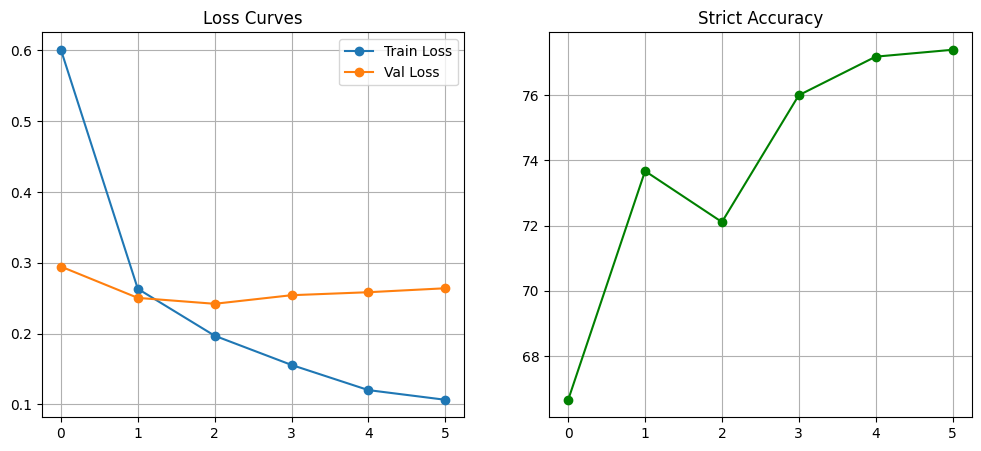


📊 CLASSIFICATION REPORT
                             precision    recall  f1-score   support

    Armed Combat & Weaponry       0.79      0.83      0.81       329
Counter-Terrorism & Arrests       0.67      0.86      0.75        98
   Crimes Against Civilians       0.75      0.85      0.79       428
       Extremist Propaganda       0.61      0.72      0.66       416
                  non-crime       0.86      0.65      0.74       764
            sexual_violence       1.00      1.00      1.00       335

                   accuracy                           0.78      2370
                  macro avg       0.78      0.82      0.79      2370
               weighted avg       0.80      0.78      0.78      2370



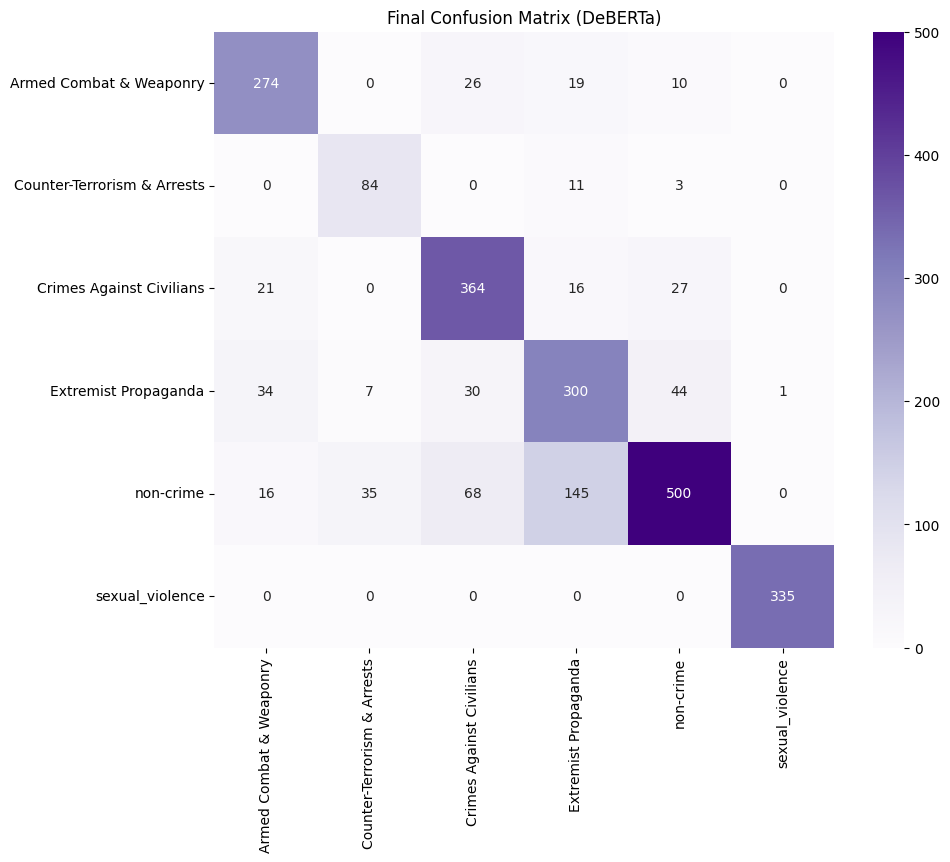

In [ ]:
# --- 7. EVALUATION ---

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['joint_acc'], label='Joint Accuracy', color='green', marker='o')
plt.title('Strict Accuracy')
plt.grid(True)
plt.show()

# Final Confusion Matrix
model.load_state_dict(torch.load(Config.SAVE_NAME)) # Load best weights
model.eval()
preds, trues = [], []

with torch.no_grad():
    for d in val_loader:
        input_ids = d["input_ids"].to(Config.DEVICE)
        mask = d["attention_mask"].to(Config.DEVICE)
        _, out_mul = model(input_ids, mask)
        preds.extend(torch.max(out_mul, dim=1)[1].cpu().numpy())
        trues.extend(d["multi_label"].cpu().numpy())

print("\n📊 CLASSIFICATION REPORT")
print(classification_report(trues, preds, target_names=unique_crimes))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(trues, preds), annot=True, fmt='d', xticklabels=unique_crimes, yticklabels=unique_crimes, cmap='Purples')
plt.title('Final Confusion Matrix (DeBERTa)')
plt.show()

In [ ]:
import torch
import os
import shutil
from google.colab import files  # Use this if on Google Colab

# 1. Define output directory
output_dir = "./crime_detection_deberta_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving to {output_dir}...")

# 2. SAVE THE WEIGHTS (Correct way for custom PyTorch models)
# We use torch.save() for the state_dictionary
weights_path = os.path.join(output_dir, "model_weights.pth")
torch.save(model.state_dict(), weights_path)

# 3. SAVE THE TOKENIZER
# The tokenizer is standard, so we CAN use save_pretrained here
tokenizer.save_pretrained(output_dir)

# 4. SAVE CONFIG (Optional but recommended)
# Save the model name so you know which base to load later
with open(os.path.join(output_dir, "config.txt"), "w") as f:
    f.write(Config.MODEL_NAME)

print("✅ Model weights and Tokenizer saved successfully!")

# ---------------------------------------------------------
# Zip and Download
# ---------------------------------------------------------
shutil.make_archive('crime_detection_model_zip', 'zip', output_dir)
print("✅ Zipped successfully. Downloading...")

try:
    files.download('crime_detection_model_zip.zip')
except:
    print("If download didn't start, check the file browser on the left!")

Saving to ./crime_detection_deberta_model...
✅ Model weights and Tokenizer saved successfully!
✅ Zipped successfully. Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- 8. SMART INFERENCE ---

def predict_smart(text):
    model.eval()

    inputs = tokenizer.encode_plus(text, max_length=128, padding='max_length', truncation=True, return_tensors='pt')
    input_ids, mask = inputs['input_ids'].to(Config.DEVICE), inputs['attention_mask'].to(Config.DEVICE)

    with torch.no_grad():
        out_bin, out_mul = model(input_ids, mask)

        prob_crime = torch.sigmoid(out_bin).item()
        probs_multi = F.softmax(out_mul, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probs_multi)
        crime_type = unique_crimes[pred_idx]
        conf = probs_multi[pred_idx]

    print(f"\n📝 INPUT: '{text}'")
    if prob_crime < 0.29:
        print(f"✅ NON-CRIME (Confidence: {(1-prob_crime)*100:.1f}%)")
    else:
        print(f"🚨 CRIME DETECTED ({crime_type})")
        print(f"   Confidence: {conf*100:.1f}%")

# Test
predict_smart("the boys sa the girl.")
predict_smart("I am so gonna kill her.")
predict_smart("I love watching action movies.")


📝 INPUT: 'the boys sa the girl.'
✅ NON-CRIME (Confidence: 94.5%)

📝 INPUT: 'I am so gonna kill her.'
🚨 CRIME DETECTED (Extremist Propaganda)
   Confidence: 44.1%

📝 INPUT: 'I love watching action movies.'
✅ NON-CRIME (Confidence: 94.1%)


In [ ]:
from sklearn.metrics import f1_score

def optimize_threshold(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    # 1. Get all probabilities
    with torch.no_grad():
        for d in loader:
            input_ids = d['input_ids'].to(device)
            mask = d['attention_mask'].to(device)
            out_bin, _ = model(input_ids, mask)
            probs = torch.sigmoid(out_bin).squeeze().cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(d['binary_label'].cpu().numpy())

    # 2. Test every possible threshold from 0.1 to 0.9
    best_f1 = 0
    best_thresh = 0.5

    for thresh in np.arange(0.1, 0.9, 0.01):
        preds = [1 if p > thresh else 0 for p in all_probs]
        f1 = f1_score(all_labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    print(f"🚀 OPTIMIZED THRESHOLD FOUND: {best_thresh:.2f}")
    print(f"   New Binary F1-Score: {best_f1*100:.2f}%")
    return best_thresh

# Run it
best_threshold = optimize_threshold(model, val_loader, Config.DEVICE)

🚀 OPTIMIZED THRESHOLD FOUND: 0.38
   New Binary F1-Score: 90.77%
